In [1]:
%pylab inline
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import sys
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *
from joblib import Parallel, delayed
import multiprocessing
import pickle
import gzip

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

Populating the interactive namespace from numpy and matplotlib


In [2]:
results = pickle.load(gzip.open('../results/anisotropic_L1_results.gz','rb'))

def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


In [3]:
x_1 = results[-1][0]
y_1 = results[-1][1]

del(results[-1])

x_min, x_max = 69.974999999999994, 133.72999999999999
y_min, y_max = 139.94999999999999, 189.71000000000001

data_error = [extractn(res,2) for res in results]

reg_error = [extractn(res,3) for res in results]
lvals = [extractn(res,4) for res in results]

# kill all nones

data_error = [item for item in data_error if item is not None]
reg_error = [item for item in reg_error if item is not None]
lvals = [item for item in lvals if item is not None]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

stress_x = results[best][0][:,0].reshape((len(x_1),len(y_1))) 
stress_y = results[best][0][:,1].reshape((len(x_1),len(y_1))) 

In [4]:
CUTOFF  = 80
N_SOLUTIONS = 24
gamma_vals = np.logspace(-5, 0, N_SOLUTIONS)


coords, deflection, boundary = read_data('../../../tractionforce/data/t2.txt')
x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=0
condition_outside = (distances2d>0) * (distances2d<=CUTOFF)

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

forward_coords = [[ [x,y] for x in x_obs_positions] for y in y_obs_positions] 
forward_coords = np.array([item for sublist in forward_coords for item in sublist])


In [5]:
x_out = np.array(forward_coords[condition_outside,0] )
y_out = np.array(forward_coords[condition_outside,1] )

x_in = np.array(forward_coords[condition_inside,0] )
y_in = np.array(forward_coords[condition_inside,1] )
G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = True)

Size of the problem is 26026


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [6]:
s_x = stress_x.flatten()[condition_inside]
s_y = stress_y.flatten()[condition_inside]

u_in_x = G_in_in_xx.dot(s_x) + G_in_in_xy.dot(s_y)
u_out_x = G_out_in_xx.dot(s_x) + G_out_in_xy.dot(s_y)

u_in_y = G_in_in_yx.dot(s_x) + G_in_in_yy.dot(s_y)
u_out_y = G_out_in_yx.dot(s_x)  + G_out_in_yy.dot(s_y)

u_x = np.zeros(forward_coords.shape[0])
u_x[condition_inside] = u_in_x
u_x[condition_outside] = u_out_x

u_y = np.zeros(forward_coords.shape[0])
u_y[condition_inside] = u_in_y
u_y[condition_outside] = u_out_y

x_forward_positions = x_1
y_forward_positions = y_1

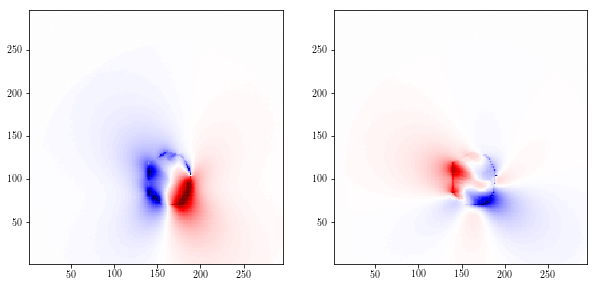

In [7]:
max_s = np.max(u_x)

noise = 1e-4

obs_x = u_x.reshape((M,N)) + np.random.normal(0,noise,size=(M,N))
obs_y = u_y.reshape((M,N)) + np.random.normal(0,noise,size=(M,N))


fig = plt.figure(figsize=(10,12))
plt.subplot(121)
 
plt.pcolormesh(x_forward_positions,y_forward_positions,obs_y.reshape((M,N)),
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')
plt.subplot(122)

plt.pcolormesh(x_forward_positions,y_forward_positions,obs_x.reshape((M,N)),
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')




In [8]:
import pandas as pd

In [9]:
len(u_y)

36100

In [10]:
len(u_x)

36100

In [11]:
len(deflection)

36100

In [12]:
df = pd.DataFrame( {"x": coords[:,0], "y": coords[:,1], "u_x": obs_x.flatten(), "u_y": obs_y.flatten(), "boundary": boundary })

In [13]:
df.to_csv("t2_generated.csv", index=False)